# Classfication of news dataset

# 单独优化 POLITICS,     	precision=0.525 recall=0.666 

In [1]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

### Load the News Categories dataset

In [2]:
import json
corpus, lables = [], []
with open('News_Category_Dataset_v2.json') as f:
    for line in f:
        obj = json.loads(line)
        corpus.append(obj['headline'] + '. ' + obj['short_description'])
        lables.append(obj['category'])
lables = np.array(lables)        
print(len(corpus))
print(len(lables))
print(corpus[-1])
print(lables[-1])


200853
200853
Dwight Howard Rips Teammates After Magic Loss To Hornets. The five-time all-star center tore into his teammates Friday night after Orlando committed 23 turnovers en route to losing
SPORTS


In [3]:
# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

def text_to_words(text):
    """Convert a raw review string into a sequence of words."""
    
    # TODO: Remove HTML tags and non-letters,
    #       convert to lowercase, tokenize,
    #       remove stopwords and stem
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    words = text.split()
    words = [w for w in words if w not in stopwords.words("english")]
    words = [PorterStemmer().stem(w) for w in words]

    # Return final list of words
    return words


text_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/brentweiliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['em',
 'test',
 'em',
 'br',
 'br',
 'test',
 'would',
 'make',
 'b',
 'great',
 'b',
 'movi',
 'review']

In [4]:
# # lower, tokenize, stemming
# corpus_words = []
# for doc in corpus:
#     corpus_words.append(text_to_words(doc))
#     if len(corpus_words) % 100 == 0:
#         print(len(corpus_words))
    

In [5]:
corpus_train, corpus_test, lables_train, lables_test = train_test_split(corpus, lables, test_size=0.2, random_state=7)
vectorizer = TfidfVectorizer(min_df=10, max_features=10000)


# corpus_train, corpus_test, y_train, y_test = train_test_split(corpus_words, y, test_size=0.2, random_state=7)
#vectorizer = TfidfVectorizer(min_df=5, max_features=20000, preprocessor=lambda x: x, tokenizer=lambda x: x)

#vectorizer = CountVectorizer()

# Average precision-recall score: 0.80
# corpus_train, corpus_test, y_train, y_test = train_test_split(corpus_words, y, test_size=0.2, random_state=7)
# vocabulary_size = 50000
# vectorizer = CountVectorizer(max_features=vocabulary_size,preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed

X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

print(f'X_train.shape = {X_train.shape}')
print(f'lables_train.shape = {lables_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'lables_test.shape = {lables_test.shape}')

X_train.shape = (160682, 10000)
lables_train.shape = (160682,)
X_test.shape = (40171, 10000)
lables_test.shape = (40171,)


In [6]:
import collections

class Clazz:
    def __init__(self, name, Y_train, Y_test):
        self.name = name
        self.Y_train = Y_train
        self.Y_test  = Y_test
        self.accuracy = None
        self.classifier = None
        
#CLASSES_SET = set(lables_test)
CLASSES_SET = {'TRAVEL', 'BUSINESS', 'HOME & LIVING', 'SPORTS', 'GOOD NEWS'}
CLASSES = []
for clazz in CLASSES_SET:
    Y_train = [1.0 if lable == clazz else 0. for lable in lables_train]
    Y_test  = [1.0 if lable == clazz else 0. for lable in lables_test]
    CLASSES.append(Clazz(clazz, Y_train, Y_test))
    print(clazz, collections.Counter(Y_train + Y_test))
    

TRAVEL Counter({0.0: 190966, 1.0: 9887})
SPORTS Counter({0.0: 195969, 1.0: 4884})
BUSINESS Counter({0.0: 194916, 1.0: 5937})
HOME & LIVING Counter({0.0: 196658, 1.0: 4195})
GOOD NEWS Counter({0.0: 199455, 1.0: 1398})


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

multi_class = None
for clazz in CLASSES:
    #clf = LogisticRegression(solver='sag', max_iter=100, random_state=42, multi_class=multi_class).fit(X_train, y_train)
    clazz.classifier = LogisticRegression(solver='liblinear', penalty = 'l2', C = 10).fit(X_train, clazz.Y_train)
    #clazz.classifier = RandomForestClassifier(n_estimators=10).fit(X_train, clazz.Y_train)
    # print the training scores
    print(f'Class = {clazz.name}')
    print("\ttraining score : %.3f " % (clazz.classifier.score(X_train, clazz.Y_train)))
    print("\ttesting score : %.3f " % (clazz.classifier.score(X_test, clazz.Y_test)))


Class = TRAVEL
	training score : 0.983 
	testing score : 0.974 
Class = SPORTS
	training score : 0.990 
	testing score : 0.984 
Class = BUSINESS
	training score : 0.981 
	testing score : 0.974 
Class = HOME & LIVING
	training score : 0.994 
	testing score : 0.989 
Class = GOOD NEWS
	training score : 0.995 
	testing score : 0.993 


### Compute the average precision score

In [8]:
from sklearn.metrics import average_precision_score
for clazz in CLASSES:
    y_predict = clazz.classifier.predict_proba(X_test)[:,1]
    average_precision = average_precision_score(clazz.Y_test, y_predict)
    print(f'Class = {clazz.name}')
    print('\tAverage precision-recall score: {0:0.2f}'.format(average_precision))
    # Average precision-recall score: 0.87

Class = TRAVEL
	Average precision-recall score: 0.78
Class = SPORTS
	Average precision-recall score: 0.66
Class = BUSINESS
	Average precision-recall score: 0.43
Class = HOME & LIVING
	Average precision-recall score: 0.77
Class = GOOD NEWS
	Average precision-recall score: 0.22


### Model evaluation 2: Plot the Precision-Recall curve


Class = TRAVEL


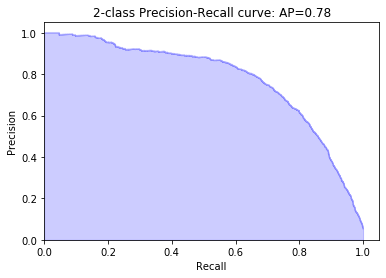

	Optimizing for F1.0 score.
	Threshold=0.307, Precision=0.733, Recall=0.719, f1.00_score=0.726
	Optimizing for F0.5 score.
	Threshold=0.613, Precision=0.857, Recall=0.573, f0.50_score=0.779
	Optimizing for F2.0 score.
	Threshold=0.117, Precision=0.561, Recall=0.831, f2.00_score=0.758

Class = SPORTS


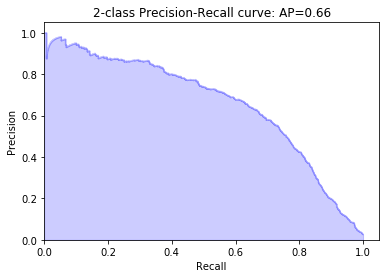

	Optimizing for F1.0 score.
	Threshold=0.249, Precision=0.657, Recall=0.637, f1.00_score=0.647
	Optimizing for F0.5 score.
	Threshold=0.539, Precision=0.773, Recall=0.475, f0.50_score=0.687
	Optimizing for F2.0 score.
	Threshold=0.102, Precision=0.507, Recall=0.758, f2.00_score=0.690

Class = BUSINESS


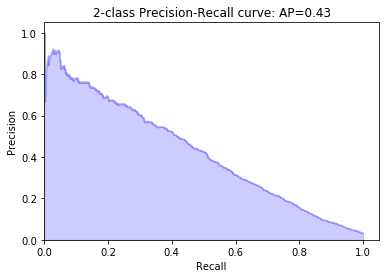

	Optimizing for F1.0 score.
	Threshold=0.252, Precision=0.477, Recall=0.447, f1.00_score=0.461
	Optimizing for F0.5 score.
	Threshold=0.518, Precision=0.629, Recall=0.284, f0.50_score=0.506
	Optimizing for F2.0 score.
	Threshold=0.076, Precision=0.280, Recall=0.646, f2.00_score=0.512

Class = HOME & LIVING


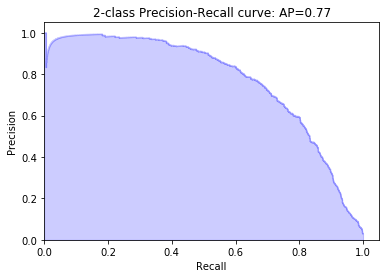

	Optimizing for F1.0 score.
	Threshold=0.291, Precision=0.742, Recall=0.691, f1.00_score=0.716
	Optimizing for F0.5 score.
	Threshold=0.696, Precision=0.903, Recall=0.514, f0.50_score=0.784
	Optimizing for F2.0 score.
	Threshold=0.125, Precision=0.590, Recall=0.802, f2.00_score=0.748

Class = GOOD NEWS


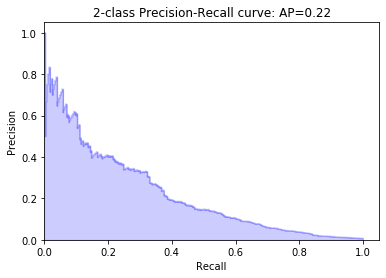

	Optimizing for F1.0 score.
	Threshold=0.161, Precision=0.330, Recall=0.323, f1.00_score=0.326
	Optimizing for F0.5 score.
	Threshold=0.299, Precision=0.406, Recall=0.216, f0.50_score=0.345
	Optimizing for F2.0 score.
	Threshold=0.046, Precision=0.146, Recall=0.517, f2.00_score=0.343


In [11]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature
def fbeta_score_pr(beta, precision, recall):
    beta2 = beta ** 2
    denominator = beta2 * precision + recall
    f_score = 0. if denominator == 0. else (1 + beta2) * precision * recall / denominator
    return f_score

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

for clazz in CLASSES:
    print(f'\nClass = {clazz.name}')
    y_predict = clazz.classifier.predict_proba(X_test)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(clazz.Y_test, y_predict)    
    average_precision = average_precision_score(clazz.Y_test, y_predict)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recalls, precisions, color='b', alpha=0.2,where='post')
    plt.fill_between(recalls, precisions, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()
    
    for beta in [1.0, 0.5, 2.0]:
        print(f'\tOptimizing for F{beta} score.')
        f_measure = [fbeta_score_pr(beta, p, r) for p, r in zip(precisions, recalls)]
        metrics_curve = np.array(list(zip(thresholds, precisions, recalls, f_measure)))
        optimal_index = np.argmax(metrics_curve[:, 3])
        threshold, precision, recall, fbeta_score = metrics_curve[optimal_index, :]
        # print(len(metrics_curve))
        # print(metrics_curve)
        print('\tThreshold=%.3f, Precision=%.3f, Recall=%.3f, f%.2f_score=%.3f' % (threshold, precision, recall, beta, fbeta_score))

# Base line of Politics class
# Optimizing for F1 score.
# threshold=0.287, precision=0.730, recall=0.812, f1_score=0.769
# Optimizing for F0.5 score.
# threshold=0.670, precision=0.865, recall=0.618, f0.5_score=0.801
# Optimizing for F2 score.
# threshold=0.162, precision=0.646, recall=0.877, f2_score=0.819

### Model evaluation 4:  AUC-ROC Curve



Class = TRAVEL


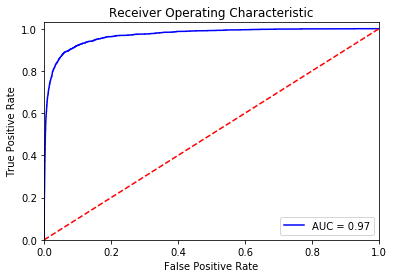


Class = BUSINESS


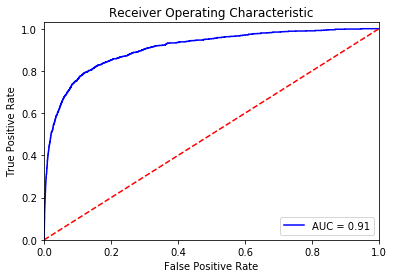


Class = GOOD NEWS


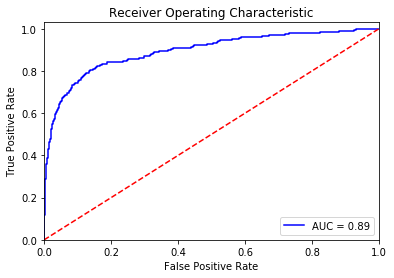


Class = SPORTS


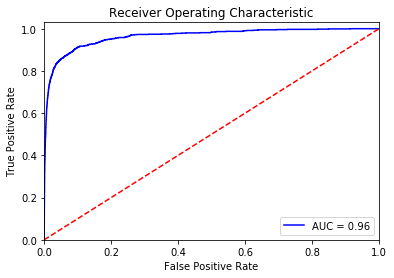


Class = HOME & LIVING


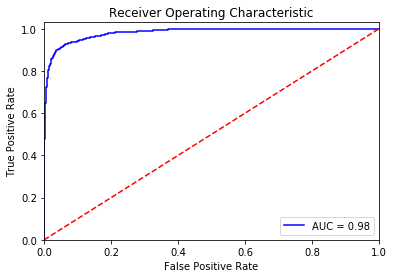

In [51]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

for clazz in CLASSES:
    print(f'\nClass = {clazz.name}')
    # calculate the fpr and tpr for all thresholds of the classification
    probs = clazz.classifier.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(clazz.Y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.03])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
# POLITCS: AUC = 0.96

## Hyperparameter selection

RandomSearchCV

In [47]:
# Grid search cross validation
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression

# grid = {"C":np.logspace(-3, 3, 7), "penalty":["l1", "l2"]}  # l1 lasso l2 ridge
# logreg = LogisticRegression()
# logreg_cv = GridSearchCV(logreg, grid, cv=10)
# logreg_cv.fit(X_train, y_train)

# print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
# print("accuracy :", logreg_cv.best_score_)

In [12]:
from sklearn.ensemble import RandomForestClassifier

for clazz in CLASSES:
    if clazz.name != 'BUSINESS':
        continue
    #clf = LogisticRegression(solver='sag', max_iter=100, random_state=42, multi_class=multi_class).fit(X_train, y_train)
    clazz.classifier = RandomForestClassifier(n_estimators=10).fit(X_train, clazz.Y_train)
    #clazz.classifier = RandomForestClassifier(n_estimators=10).fit(X_train, clazz.Y_train)
    # print the training scores
    print(f'Class = {clazz.name}')
    print("\ttraining score : %.3f " % (clazz.classifier.score(X_train, clazz.Y_train)))
    print("\ttesting score : %.3f " % (clazz.classifier.score(X_test, clazz.Y_test)))



Class = TRAVEL
	training score : 0.996 
	testing score : 0.961 
Class = SPORTS
	training score : 0.997 
	testing score : 0.979 
Class = BUSINESS
	training score : 0.995 
	testing score : 0.972 
Class = HOME & LIVING
	training score : 0.998 
	testing score : 0.984 
Class = GOOD NEWS
	training score : 0.998 
	testing score : 0.993 


In [13]:
from sklearn.metrics import average_precision_score
for clazz in CLASSES:
    y_predict = clazz.classifier.predict_proba(X_test)[:,1]
    average_precision = average_precision_score(clazz.Y_test, y_predict)
    print(f'Class = {clazz.name}')
    print('\tAverage precision-recall score: {0:0.2f}'.format(average_precision))
    # Average precision-recall score: 0.87

Class = TRAVEL
	Average precision-recall score: 0.57
Class = SPORTS
	Average precision-recall score: 0.45
Class = BUSINESS
	Average precision-recall score: 0.25
Class = HOME & LIVING
	Average precision-recall score: 0.55
Class = GOOD NEWS
	Average precision-recall score: 0.04
